In [17]:
import cv2
import PIL
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

import torch
from torch import nn
from torch.autograd import Variable, Function
from torchvision import models, transforms
from torch import optim

%matplotlib inline

In [2]:
tmp = "".join(open("labels.txt", 'r').readlines()).replace("\n", "")
labeldict = eval(tmp)

In [3]:
torch.cuda.set_device(3)

In [4]:
model_ev = models.inception_v3(pretrained=True, transform_input=False).eval().cuda()

/home/lestsovba/anaconda3/lib/python3.6/site-packages/torchvision-0.1.9-py3.6.egg/torchvision/models/inception.py:65: UserWarning: src is not broadcastable to dst, but they have the same number of elements.  Falling back to deprecated pointwise behavior.


In [5]:
path = "/home/lestsovba/pic/car.jpg"
im1 = cv2.imread(path)
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)

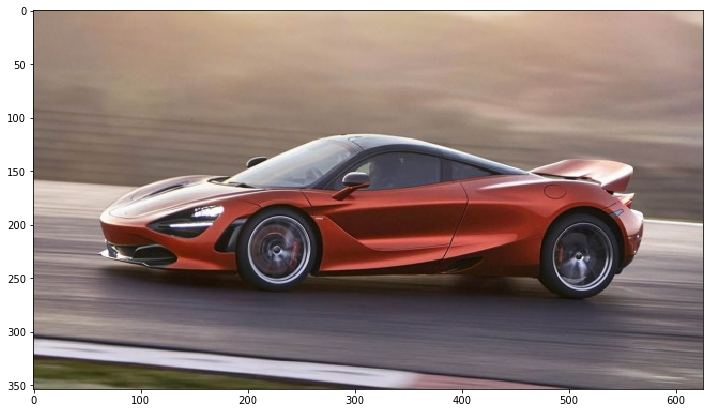

In [7]:
plt.figure(figsize=(12,10))
plt.imshow(im1)

In [8]:
f = open(path, 'rb')
im1 = Image.open(f)

In [9]:
normalize = transforms.Normalize(mean=[0.406, 0.456, 0.485],
                                 std=[0.225, 0.224, 0.229])
tr = transforms.Compose([
        transforms.Scale(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        normalize,
        ])


In [10]:
res = model_ev.forward(img)

print(res)
res = nn.Softmax()(res)
prob, ind = torch.topk(res, 5)

for i in range(ind.size()[1]):
    print(labeldict[ind[0][i].data[0]], " : ", prob[0][i].data[0])

NameError: name 'img' is not defined

In [11]:
class FeatureExtractor(nn.Module):
    def __init__(self, submodule, extracted_layers):
        super(FeatureExtractor, self).__init__()
        self.submodule = submodule
        self.extracted_layers = extracted_layers

    def forward(self, x):
        outputs = []
        for name, module in self.submodule._modules.items():
            if name in 'fc':
                continue
            if not name in ['AuxLogits']:
                x = module(x)
                if name in self.extracted_layers:
                    outputs += [x]
            else:
                continue
                
        return outputs + [x]

In [49]:
for i, (name, module) in enumerate(model_ev._modules.items()):
    print(i, name, module)

0 Conv2d_1a_3x3 BasicConv2d (
  (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True)
)
1 Conv2d_2a_3x3 BasicConv2d (
  (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True)
)
2 Conv2d_2b_3x3 BasicConv2d (
  (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True)
)
3 Conv2d_3b_1x1 BasicConv2d (
  (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True)
)
4 Conv2d_4a_3x3 BasicConv2d (
  (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True)
)
5 Mixed_5b InceptionA (
  (branch1x1): BasicConv2d (
    (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64,

In [12]:
extr = FeatureExtractor(model_ev, ['Mixed_5c'])

In [13]:
grad = []

def hook(grad_):
    #print(grad)
    global grad
    grad = grad_
    return img

In [26]:
h.remove()

In [493]:
del model_ev
del extr

NameError: name 'model_ev' is not defined

In [62]:
normalize = transforms.Normalize(mean=[0.406, 0.456, 0.485],
                                 std=[0.225, 0.224, 0.229])
tr = transforms.Compose([
        transforms.Scale(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        normalize,
        ])

In [98]:
img = tr(im1)
img = Variable(img.unsqueeze(0).cuda(), requires_grad=True)
#h = img.register_hook(hook)

In [102]:
img = np.random.randint(70, 170, size=(299,299,3), dtype=np.uint8)
img = Image.fromarray(img)
img = tr(img)
img = Variable(img.unsqueeze(0).cuda(), requires_grad=True)
#h = img.register_hook(hook)

In [108]:
opt = optim.Adam([img], lr=0.25)

In [107]:
iters = 200
#lr = 1.05

In [109]:
for i in range(iters):
    grad = []
    opt.zero_grad()
    
    tmp = img.data.cpu().numpy()
    w_jit = np.random.randint(-16, 16)
    h_jit = np.random.randint(-16, 16)
    tmp = np.roll(tmp, h_jit ,axis=[2])
    tmp = np.roll(tmp, w_jit ,axis=[3])
    img.data = torch.FloatTensor(tmp).cuda()
    
    res = extr.forward(img)[0]
    
    diff = torch.sum(res[0, :, :, :].pow(2))/float(np.prod(res.size()))
    diff.backward()
    
    opt.step()
    #img.data += lr*grad.data/grad.abs().mean().data
    
    tmp = img.data.cpu().numpy()
    tmp = np.roll(tmp, -h_jit ,axis=[2])
    tmp = np.roll(tmp, -w_jit ,axis=[3])
    img.data = torch.FloatTensor(tmp).cuda()

In [38]:
renormalize = transforms.Normalize(mean=[-1./0.406, -1./0.456, -1./0.485],
                                   std=[1./0.225, 1./0.224, 1./0.229])

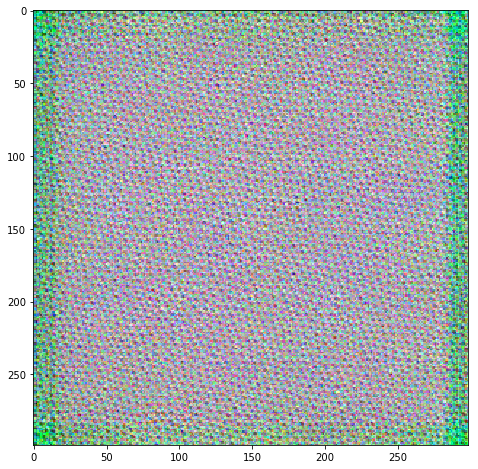

In [110]:
res_img = renormalize(img.data.cpu()).numpy()[0].clip(0,1).transpose(1,2,0)
plt.figure(figsize=(10,8))
plt.imshow(res_img)

In [177]:
w_jit = np.random.randint(-8, 8)
h_jit = np.random.randint(-8, 8)
tmp = np.roll(tmp, h_jit ,axis=[2])
tmp = np.roll(tmp, w_jit ,axis=[3])

In [178]:
img.data = torch.FloatTensor(tmp).cuda()

In [115]:
img = img.cuda()